# Time Forecasting


### Load the data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [ ]:
df = pd.read_csv('data/sales_invoiced_lines_basics_cleaned_clustered.csv')
df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')

In [11]:
cluster_type = 'KMeans'

### Create a cluster based time analysis

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
cluster_time_trends = []
for cluster in sorted(df['Cluster_' + cluster_type].unique()):
    series = df[df["Cluster_" + cluster_type] == cluster].groupby('Date')['Quantity'].sum()
    series.index = pd.to_datetime(series.index)
    series = series.asfreq('D').fillna(0)
    
    result = seasonal_decompose(series, model='additive')
    
    seasonality_strength = result.seasonal.std() / series.std()
    trend_strength = result.trend.dropna().std() / series.std()
    residual_strength = result.resid.dropna().std() / series.std()
    
    seasonality = 'high' if seasonality_strength > 0.5 else 'low'
    trend = 'high' if trend_strength > 0.5 else 'low'
    volatility = 'high' if residual_strength > 0.5 else 'low'
    print(f'Cluster {cluster}: Seasonality is {seasonality}, Trend is {trend}, Volatility is {volatility}')
    cluster_time_trends.append((cluster, seasonality, trend, volatility))

Cluster 0: Seasonality is high, Trend is low, Volatility is high
Cluster 1: Seasonality is low, Trend is low, Volatility is high
Cluster 2: Seasonality is low, Trend is low, Volatility is high
Cluster 3: Seasonality is high, Trend is high, Volatility is high
Cluster 4: Seasonality is high, Trend is low, Volatility is high
Cluster 5: Seasonality is low, Trend is low, Volatility is high
Cluster 6: Seasonality is high, Trend is low, Volatility is high
Cluster 7: Seasonality is high, Trend is low, Volatility is high
Cluster 8: Seasonality is high, Trend is low, Volatility is high
Cluster 9: Seasonality is low, Trend is low, Volatility is high


These components are defined as follows:

Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.

Simple Clusters (low seasonality): Use ARIMA.

Complex Seasonality: Use Prophet.

Highly Non-linear Clusters: Consider LSTM or other deep learning methods.

Small Data Clusters: If clusters have limited data, use simpler models like Exponential Smoothing or SARIMA.

### Prophet Attempt

09:18:16 - cmdstanpy - INFO - Chain [1] start processing
09:18:17 - cmdstanpy - INFO - Chain [1] done processing


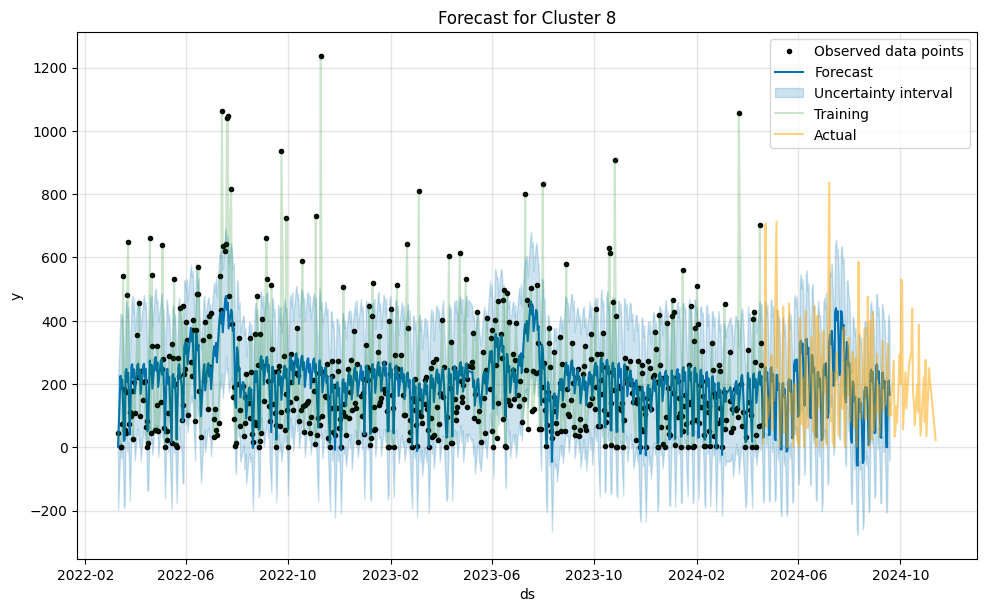

1081.1


In [ ]:
from prophet import Prophet
def forecast_prophet(params = None, show_plot = True):
    # Loop through each cluster and forecast
    for cluster in cluster_time_trends:
        if cluster[1] == 'low':
            continue
        cluster_data = df[df['Cluster_' + cluster_type]'] == cluster[0]].groupby('Date')['Quantity'].sum().reset_index()
        cluster_data.rename(columns={'Date': 'ds', 'Quantity': 'y'}, inplace=True)
        
        # Split the data into training and testing sets
        train_size = int(len(cluster_data) * 0.8)
        train_data = cluster_data[:train_size]
        test_data = cluster_data[train_size:]
        
        if params is not None:
            model = Prophet(**params)
        else:
            model = Prophet()
        model.fit(train_data)
        
        future = model.make_future_dataframe(periods=len(test_data))
        forecast = model.predict(future)
        
        # Plot forecast
        if show_plot:
            fig = model.plot(forecast)
            plt.title(f'Forecast for Cluster {cluster[0]}')
            plt.plot(train_data['ds'], train_data['y'], color='green', alpha=0.2, label='Training')
            plt.plot(test_data['ds'], test_data['y'], color='orange', alpha=0.5, label='Actual')
            plt.legend()
            plt.show()

        error = mape(test_data['y'], forecast['yhat'])
        return error
    
print(forecast_prophet())

**Prophet with hyper parameter optimization using MANGO**

In [ ]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
from scipy.stats import uniform
from mango import scheduler, Tuner

param_space = dict(growth = ['linear', 'logistic', 'flat'],
                   n_changepoints  = range(0, 55, 5),
                   changepoint_range  = uniform(0.5, 0.5),
                   yearly_seasonality = [True, False],
                   weekly_seasonality = [True, False],
                   daily_seasonality = [True, False],
                   seasonality_mode = ['additive', 'multiplicative'],
                   seasonality_prior_scale=uniform(5.0, 15.0),
                   changepoint_prior_scale=uniform(0.0, 0.1),
                   interval_width = uniform(0.2, 0.8),
                   uncertainty_samples = [500, 1000, 1500, 2000]
                   )

def objective_function(args_list):
    global train_df, test_df
    
    params_evaluated = []
    results = []
    
    
    for params in args_list:
        try:
            error = forecast_prophet(params, show_plot=False)
            params_evaluated.append(params)
            results.append(error)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(100000000)# Giving high loss for exceptions regions of spaces
        
        #print(params_evaluated, mse)
    return params_evaluated, results

conf_Dict = dict()
conf_Dict['initial_random'] = 10
conf_Dict['num_iteration'] = 50
tuner = Tuner(param_space, objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])



Best score: 834.62: 100%|██████████| 50/50 [03:26<00:00,  4.14s/it]

best parameters: {'changepoint_prior_scale': 0.03603921428164384, 'changepoint_range': 0.7136010623751028, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.21782158579219085, 'n_changepoints': 40, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 11.011984905048163, 'uncertainty_samples': 1500, 'weekly_seasonality': True, 'yearly_seasonality': False}
best loss: 834.62


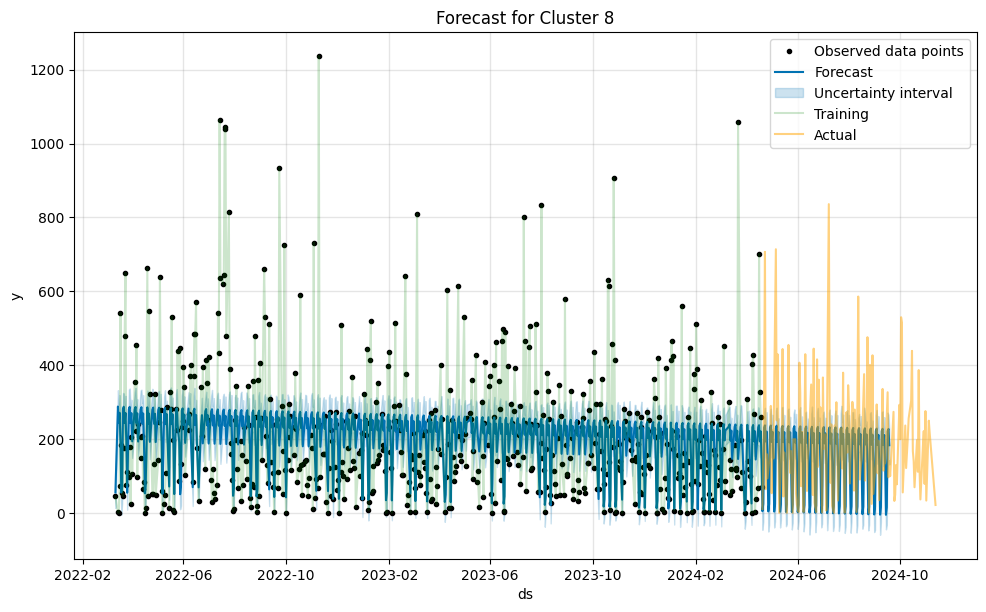

834.62

In [ ]:
forecast_prophet(results['best_params'])

### Using DARTS Library with different models 

#### XGBoost

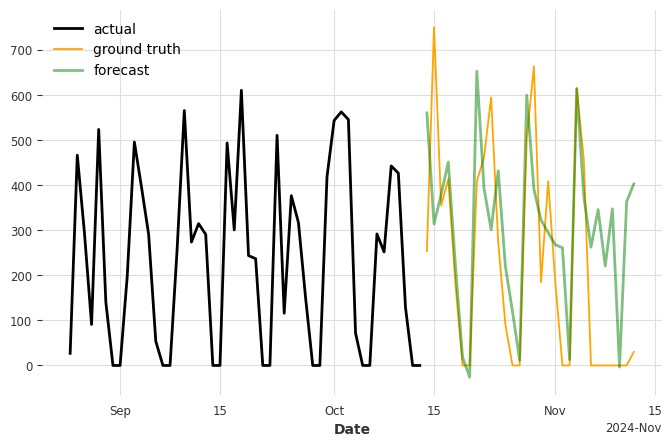

In [ ]:
from darts.models import XGBModel
from darts import TimeSeries
target = df[df['Cluster_' + cluster_type]_'+ cluster_type] == 0].groupby('Date')['Quantity'].sum().asfreq('D').fillna(0)[:-30]
# set target as TimeSeries
target = TimeSeries.from_series(target)
model = XGBModel(
    lags=12,
    output_chunk_length=6,
)
model.fit(target)
pred = model.predict(30)


plt.figure(figsize=(8, 5))
target[-50:].plot(label='actual')
ground_truth = df[df['Cluster_' + cluster_type]_' + cluster_type] == 0].groupby('Date')['Quantity'].sum().asfreq('D').fillna(0)[-30:]
plt.plot(ground_truth.index, ground_truth, label='ground truth', color='orange')
pred.plot(label='forecast', lw=2, color = 'green', alpha = 0.5)
plt.legend()
plt.show()

</details>

#### GARCH Models

In [13]:
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries
from arch import arch_model

In [17]:
series = df[df['Cluster_' + cluster_type] == 0].groupby('Date')['Quantity'].sum().asfreq('D').fillna(0)
# Prepare the data for the GARCH model
returns = series

# Define and fit the GARCH(1,1) model
garch_model = arch_model(returns, vol='GARCH', p=1, q=1, dist='normal')
garch_results = garch_model.fit(update_freq=10)

# Print the model summary
print(garch_results.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: 6723.351792725319
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               Quantity   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6723.35
Distribution:                  Normal   AIC:                           13454.7
Method:            Maximum Likelihood   BIC:                           13474.2
                                        No. Observations:                  977
Date:                Wed, Nov 20 2024   Df Residuals:                      976
Time:                        00:06:39   Df Model:                            1
                                 Mean Model                                 
     

C:\Users\Thomas\AppData\Roaming\Python\Python312\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.563e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


C:\Users\Thomas\AppData\Roaming\Python\Python312\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.441e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:     67,   Neg. LLF: 6900.920617897297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6900.9206064495775
            Iterations: 12
            Function evaluations: 78
            Gradient evaluations: 12


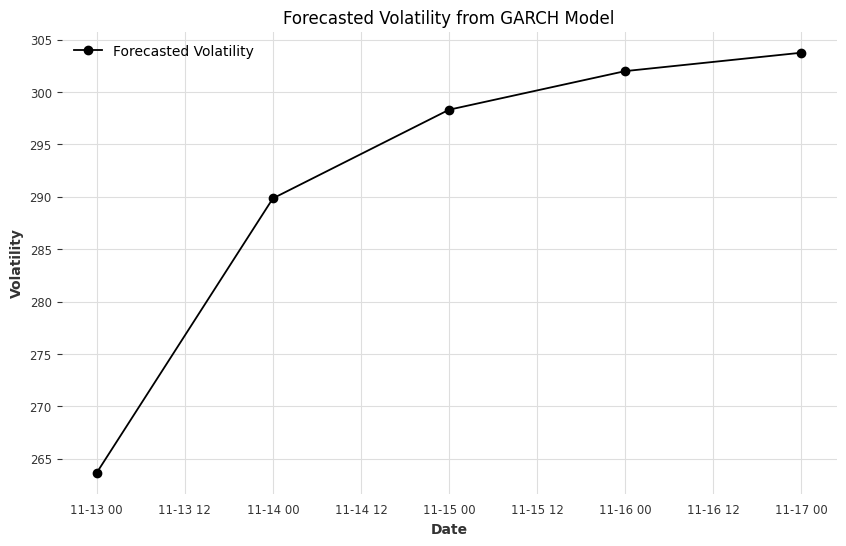

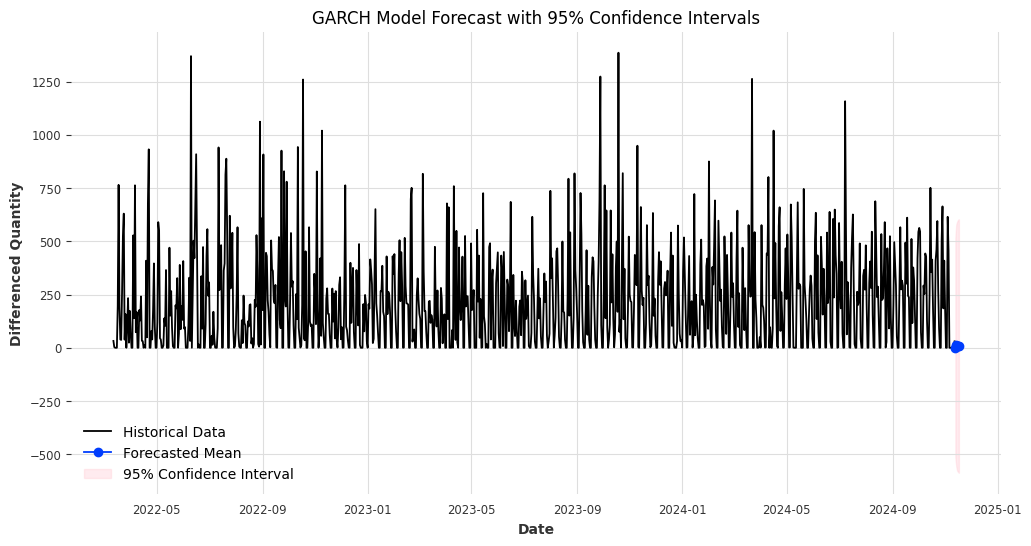

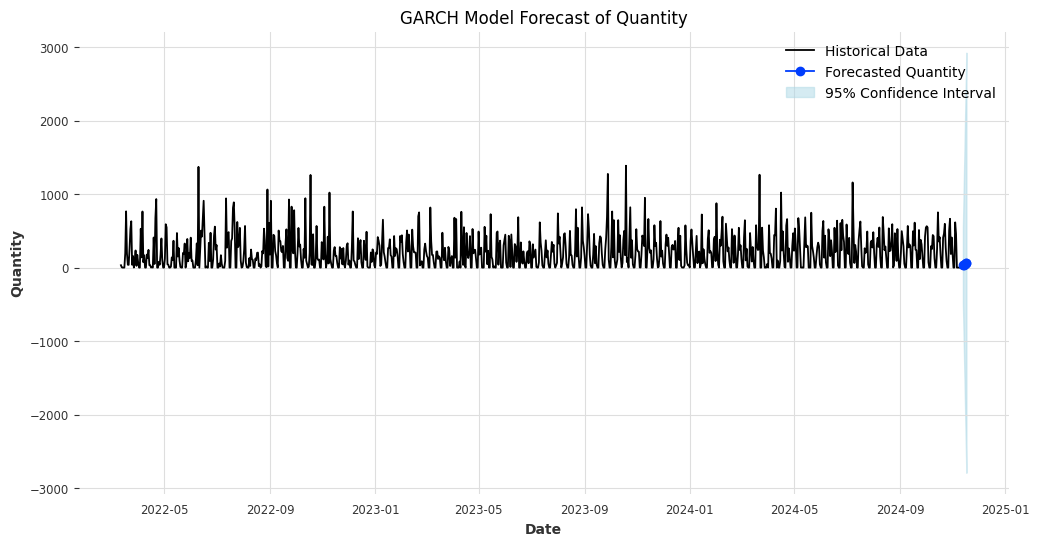

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# Assuming 'series' is your time series data prepared as before

# Step 1: Prepare the data (e.g., first differencing)
returns = series.diff().dropna().values.flatten()

# Step 2: Fit the GARCH model with an AR(1) mean model
garch_model = arch_model(returns, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal')
garch_results = garch_model.fit(update_freq=10)

# Step 3: Generate forecasts
forecast_horizon = 5
forecasts = garch_results.forecast(horizon=forecast_horizon)

# Step 4: Extract forecasted mean and variance
mean_forecasts = forecasts.mean.iloc[-forecast_horizon:]
variance_forecasts = forecasts.variance.iloc[-forecast_horizon:]
std_forecasts = np.sqrt(variance_forecasts)

# Step 5: Create a date index for the forecast period
last_date = series.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

# Step 6: Visualize the forecasted volatility
std_forecasts_values = std_forecasts.values.flatten()
volatility_forecast_series = pd.Series(std_forecasts_values, index=forecast_dates)

plt.figure(figsize=(10, 6))
plt.plot(volatility_forecast_series, marker='o', linestyle='-', label='Forecasted Volatility')
plt.title('Forecasted Volatility from GARCH Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Step 7: Visualize the forecasted mean with confidence intervals
mean_forecasts_values = mean_forecasts.values.flatten()
z_score = 1.96  # For 95% confidence interval
upper_bounds = mean_forecasts_values + z_score * std_forecasts_values
lower_bounds = mean_forecasts_values - z_score * std_forecasts_values

forecast_df = pd.DataFrame({
    'Mean Forecast': mean_forecasts_values,
    'Upper Bound': upper_bounds,
    'Lower Bound': lower_bounds
}, index=forecast_dates)

plt.figure(figsize=(12, 6))
plt.plot(series.index, series.values, label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Mean Forecast'], label='Forecasted Mean', marker='o')
plt.fill_between(forecast_df.index, forecast_df['Lower Bound'], forecast_df['Upper Bound'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('GARCH Model Forecast with 95% Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Differenced Quantity')
plt.legend()
plt.show()

# Step 8: Convert forecasts back to original scale (optional)
last_value = series.iloc[-1]
cumulative_forecasts = np.cumsum(mean_forecasts_values)
original_scale_forecasts = last_value + cumulative_forecasts

cumulative_upper_bounds = last_value + np.cumsum(upper_bounds)
cumulative_lower_bounds = last_value + np.cumsum(lower_bounds)

forecast_df['Quantity Forecast'] = original_scale_forecasts
forecast_df['Upper Bound (Quantity)'] = cumulative_upper_bounds
forecast_df['Lower Bound (Quantity)'] = cumulative_lower_bounds

plt.figure(figsize=(12, 6))
plt.plot(series.index, series.values, label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Quantity Forecast'], label='Forecasted Quantity', marker='o')
plt.fill_between(forecast_df.index, forecast_df['Lower Bound (Quantity)'], forecast_df['Upper Bound (Quantity)'], color='lightblue', alpha=0.5, label='95% Confidence Interval')
plt.title('GARCH Model Forecast of Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()
